In [1]:
import os
import sys
import timeit
import numpy as np
from pydub import AudioSegment
import pydub
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline


In [2]:
#GENRE_DIR = "/home/mike/Desktop/EE379K/FinalProject/genres"
BASE_DIR = "C:/Users/Mike/Documents/EE379K/FinalProject/EE379K"
GENRE_DIR = BASE_DIR + "/genres"
MODEL_DIR = BASE_DIR + "/models"
GENRE_LIST = ("blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock")

In [ ]:
def convert_dataset_to_wav():
    """
        Converts all files of the GTZAN dataset
        to the WAV (uncompressed) format.
    """
    start = timeit.default_timer()

    for subdir, dirs, files in os.walk(GENRE_DIR):
        print("Converting au to wav " + subdir)
        for file in files:
            path = subdir+'/'+file
            
            if path.endswith("au"):
                song = AudioSegment.from_file(path,"au")
                song = song[:30000]
                song.export(path[:-3]+".wav",format='wav')

    stop = timeit.default_timer()
    print ("Conversion time = ", (stop - start))
    
convert_dataset_to_wav()

In [71]:
for subdir, dirs, files in os.walk(GENRE_DIR):
        for file in files:
            path = subdir+'/'+file
            if not path.endswith("wav"):
                os.remove(path)

(64, 1292)


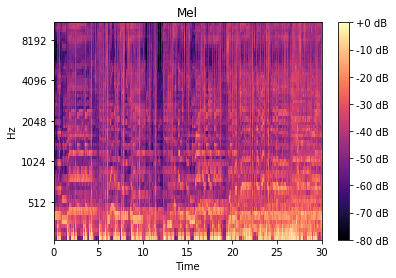

(13, 1292)


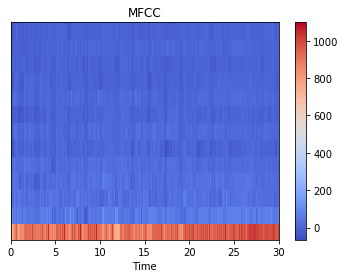

(12, 1292)


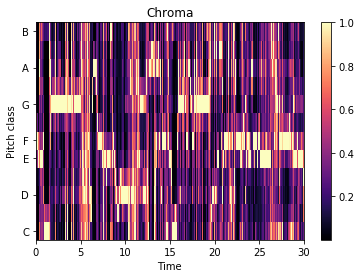

(192, 1292)


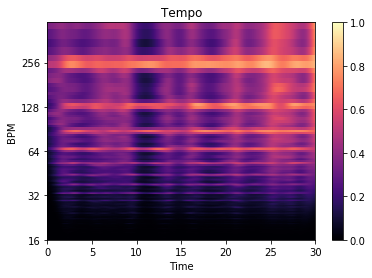

(1, 1292)


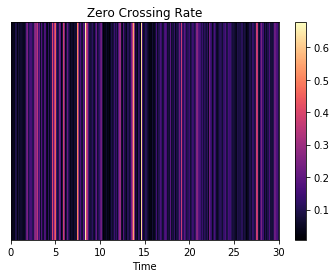

(20, 1292)
(1, 1292)
(1, 1292)


In [147]:
from librosa import display
hop_length = 512
genre = 'pop'

sr, y = scipy.io.wavfile.read(GENRE_DIR + '/'+ genre + '/' + genre + '.00000.wav')
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
print(mel.shape)
plt.title('Mel')
librosa.display.specshow(librosa.power_to_db(mel,ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
print(mfcc.shape)
plt.title('MFCC')
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.show()

#spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
#print(spectral_center.shape)
#plt.title('Spectral Centroid')
#librosa.display.specshow(spectral_center, y_axis='log', x_axis='time')
#plt.show()

chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
print(chroma.shape)
plt.title('Chroma')
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.show()

tempo = librosa.feature.tempogram(y=y, sr=sr, win_length=192)
print(tempo.shape)
plt.title('Tempo')
librosa.display.specshow(tempo, y_axis='tempo', x_axis='time')
plt.colorbar()
plt.show()

#tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
#print(tonnetz.shape)
#plt.title('Tonnetz')
#librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
#plt.show()

zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
print(zcr.shape)
plt.title('Zero Crossing Rate')
librosa.display.specshow(zcr, x_axis='time')
plt.colorbar()
plt.show()

print(librosa.feature.mfcc(y=y, sr=sr).shape)
print(librosa.feature.spectral_centroid(y=y, sr=sr).shape)
print(librosa.feature.spectral_rolloff(y=y, sr=sr).shape)






In [12]:
import os
import glob
import sys
import numpy as np
import scipy
import scipy.io.wavfile
import librosa
import math

def create_npy(fn, data_size, hop_length, num_splits):
    """
        Creates the MFCC features. 
    """    
    sr, y = scipy.io.wavfile.read(fn)
    y.resize(data_size)
    data_length = math.floor(data_size / hop_length)
    
    n_mfcc = 20
    n_mels = 64
    split_size = math.floor(data_length / num_splits)
    adjusted_data_length = num_splits*split_size
    
    data = np.zeros((adjusted_data_length, n_mfcc+14), dtype=np.float64)
        
    #mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
    #tempo = librosa.feature.tempogram(y=y, sr=sr, win_length=192)
    zcr = librosa.feature.zero_crossing_rate(y=y, hop_length=hop_length)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    sp_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)
    sp_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)
    
    
    #mel = librosa.power_to_db(mel,ref=np.max)
    
    data[:, 0:n_mfcc] = mfcc.T[0:adjusted_data_length, :]
    data[:, n_mfcc:n_mfcc+12] = chroma.T[0:adjusted_data_length, :]
    data[:, n_mfcc+12:n_mfcc+13] = zcr.T[0:adjusted_data_length, :]
    data[:, n_mfcc+12:n_mfcc+13] = sp_centroid.T[0:adjusted_data_length, :]
    data[:, n_mfcc+13:n_mfcc+14] = sp_rolloff.T[0:adjusted_data_length, :]
    #data[:, n_mfcc+14:n_mfcc+n_mels+14] = mel.T[0:adjusted_data_length, :]
    #data[:, 91:283] = tempo.T[0:data_length, :]

    


    base_fn, ext = os.path.splitext(fn)
    for i in range(1, num_splits+1):
        np.save(base_fn + ('-%d' % i) + ext, data[(i-1)*split_size:i*split_size, :])

    


def read_npy(train_fraction, songs_per_class, genre_list=GENRE_LIST, base_dir=GENRE_DIR):
    """
        Reads the MFCC features from disk and
        returns them in a numpy array.
    """
    X = []
    y = []
    X_test = []
    y_test = []
    num_songs = songs_per_class*train_fraction
    for label, genre in enumerate(genre_list):
        i = 0
        for fn in glob.glob(os.path.join(base_dir, genre, "*.npy")):
            npy = np.load(fn)
            
            if(i >= songs_per_class):
                break

            if(i < num_songs):
                X.append(npy)
                y.append(label)
            else:
                X_test.append(npy)
                y_test.append(label)  
            
            i += 1

    return np.array(X), np.array(y), np.array(X_test), np.array(y_test)



In [13]:
song_length=661500
hop_length = 512
num_splits=6

start = timeit.default_timer()
for subdir, dirs, files in os.walk(GENRE_DIR):
    traverse = list(set(dirs).intersection( set(GENRE_LIST) ))
    break
print("Working with these genres --> ", traverse)
print("Starting npy generation") 
for subdir, dirs, files in os.walk(GENRE_DIR):
    print("Converting " + subdir)
    for file in files:
        path = subdir+'/'+file
        if path.endswith("wav"):
            tmp = subdir[subdir.rfind('\\',0)+1:]
            if tmp in traverse:
                create_npy(path, song_length, hop_length, num_splits)

stop = timeit.default_timer()
print("Total npy generation and feature writing time (s) = ", (stop - start))

Working with these genres -->  ['reggae', 'rock', 'jazz', 'blues', 'country', 'classical', 'pop', 'disco', 'metal', 'hiphop']
Starting npy generation
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\blues
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\classical
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\country
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\disco
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\hiphop
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\jazz
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\metal
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\pop
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\reggae
Converting C:/Users/Mike/Documents/EE379K/FinalProject/EE379K/genres\rock
Total npy generation and fe

In [16]:
songs_per_class=600
train_fraction = 0.9

In [17]:
X, y, X_test, y_test = read_npy(train_fraction, songs_per_class)
print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)


(5400, 215, 34)
(5400,)
(600, 215, 34)
(600,)


In [243]:
#randomize data here

In [18]:
from keras.utils.np_utils import to_categorical
import tensorflow

y = to_categorical(y, nb_classes=10)
y_test = to_categorical(y_test, nb_classes=10)
print(y.shape)
print(y_test.shape)

(5400, 10)
(600, 10)


In [19]:
np.save(BASE_DIR + "/X_trainLARGE3", X)
np.save(BASE_DIR + "/X_testLARGE3", X_test)
np.save(BASE_DIR + "/y_trainLARGE3", y)
np.save(BASE_DIR + "/y_trestLARGE3", y_test)

In [4]:
X = np.load(BASE_DIR + "/X_trainLARGE2.npy")
X_test = np.load(BASE_DIR + "/X_testLARGE2.npy")
y = np.load(BASE_DIR + "/y_trainLARGE2.npy")
y_test = np.load(BASE_DIR + "/y_trestLARGE2.npy")

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(5400, 215, 98)
(600, 215, 98)
(5400, 10)
(600, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, Nadam, SGD
from keras.layers.wrappers import Bidirectional



model = Sequential()
#model.add(Conv1D(nb_filter=64, filter_length=3, border_mode='same', activation='relu', input_shape=(1292, 92)))
#model.add(MaxPooling1D(pool_length=2))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(215, 34)))
model.add(Bidirectional(LSTM(128)))
#model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

opt = Adam(lr=0.003) #0.001, 0.005, 0.01
#opt = Nadam(lr=0.1)
#opt = SGD(lr=0.005)

#stopper = EarlyStopping(monitor='loss', min_delta=0.01, patience=5)
checkpointer = ModelCheckpoint(filepath=MODEL_DIR+"/model_batch128/weights_128.{epoch:03d}-{acc:.4f}-{loss:.4f}.hdf5", 
                               monitor='loss', save_best_only=True, verbose=1, period=1)

#model.load_weights(MODEL_DIR+"/model_batch128/weights_128.037-0.9656-0.2090.hdf5")

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

hist = model.fit(X, y, nb_epoch=25, batch_size=128, validation_data=[X_test, y_test], callbacks=[checkpointer], verbose=2, initial_epoch=0)
# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
bidirectional_11 (Bidirectional) (None, 215, 256)      166912      bidirectional_input_6[0][0]      
____________________________________________________________________________________________________
bidirectional_12 (Bidirectional) (None, 256)           394240      bidirectional_11[0][0]           
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 32)            8224        bidirectional_12[0][0]           
____________________________________________________________________________________________________
dense_15 (Dense)                 (None, 10)            330         dense_14[0][0]                   
Total params: 569,706
Trainable params: 569,706
Non-trainable params: 0
___________________

Accuracy: 17.00%
Cross Entropy: 3.34


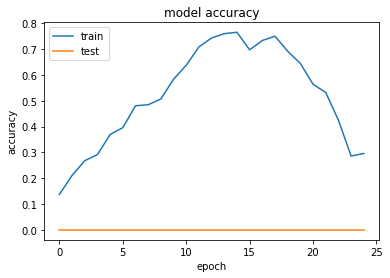

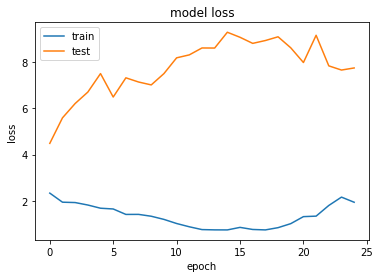

In [9]:
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Cross Entropy: %.2f" % scores[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#32, 32 lstm, w/ mel, chroma, zcr, mfcc, sp_centroid, sp_rolloff
#sgd 0.01

Accuracy: 12.00%
Cross Entropy: 2.31


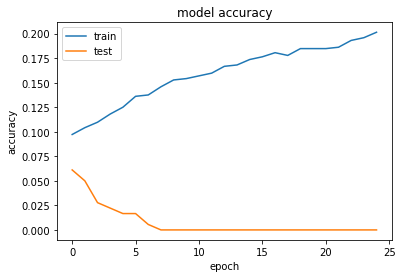

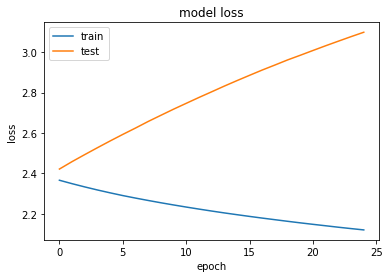

In [12]:
print("Accuracy: %.2f%%" % (scores[1]*100))
print("Cross Entropy: %.2f" % scores[0])

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64, 64 lstm, w/ mel, chroma, zcr, mfcc, sp_centroid, sp_rolloff (xtrain2)
#sgd 0.01

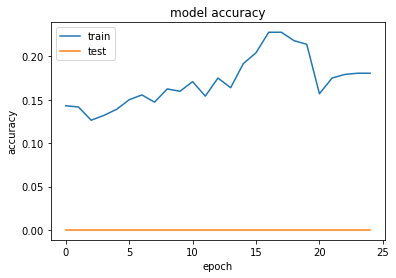

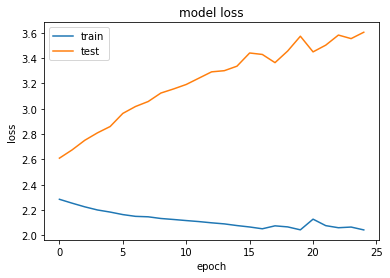

In [8]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64, 64 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#sgd 0.01

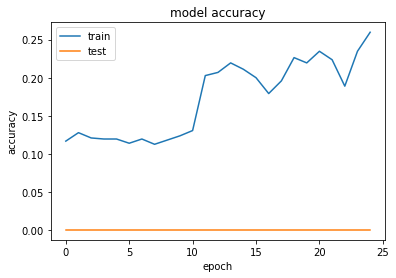

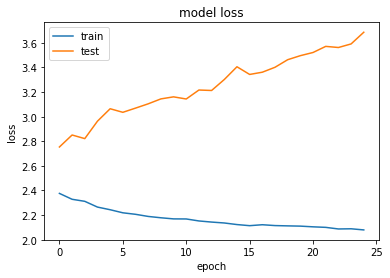

In [10]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff (xtrain3)
#sgd 0.01

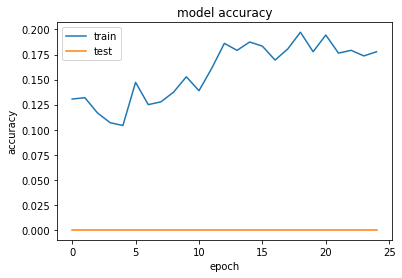

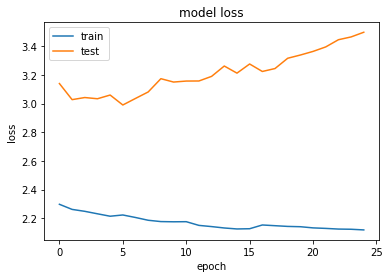

In [16]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64 lstm, w/ chroma, mfcc, sp_centroid, sp_rolloff (xtrain)
#sgd 0.01

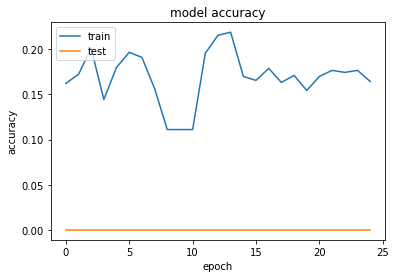

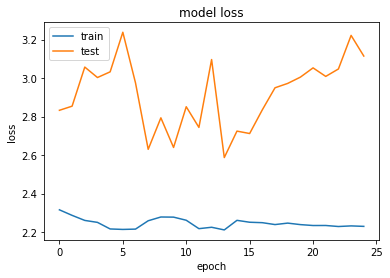

In [25]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64, 64 lstm, w/ mfcc (xtrain4) & all data (10% for validation set)
#sgd 0.01

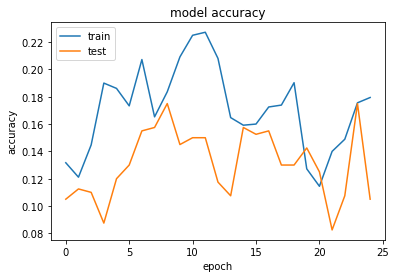

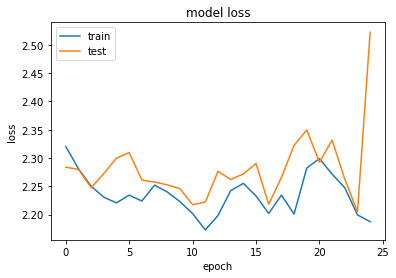

In [52]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#64, 64 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff 
#split data into groups of 4 (4 times the samples, each 4 times shorter) (XtrainLARGE)
#sgd 0.01

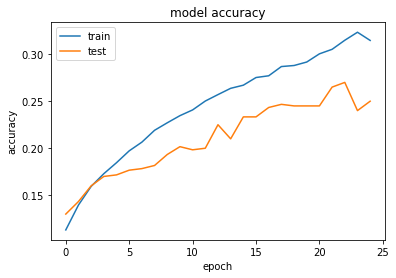

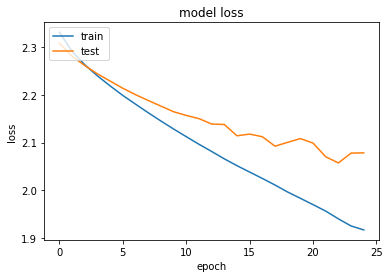

In [82]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff, mel???
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE2)
#sgd 0.1

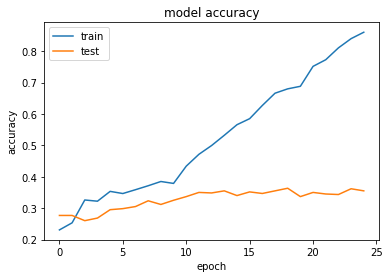

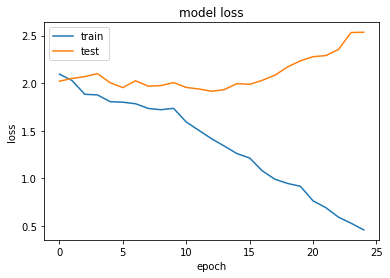

In [6]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff, mel 
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE2)
#adam 0.005

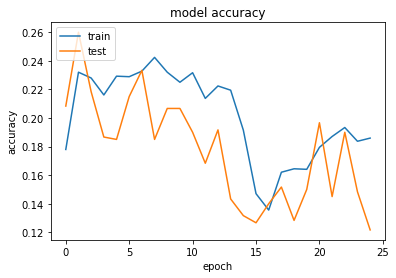

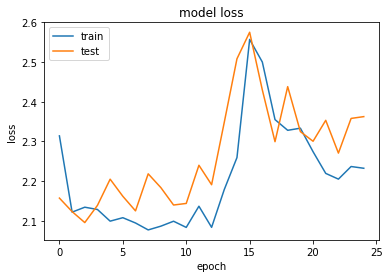

In [6]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff, mel w/ 0.2 input and hidden dropout
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE2)
#adam 0.01

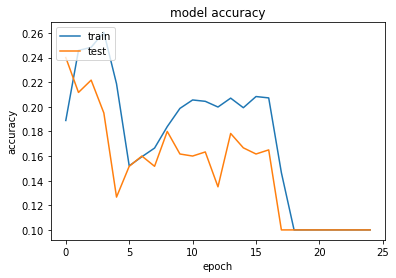

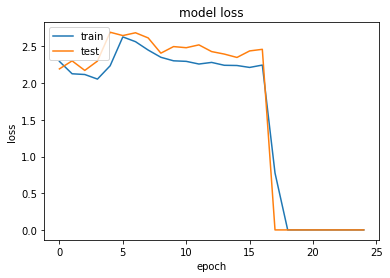

In [11]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff, mel 
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE2)
#adam 0.1 bad

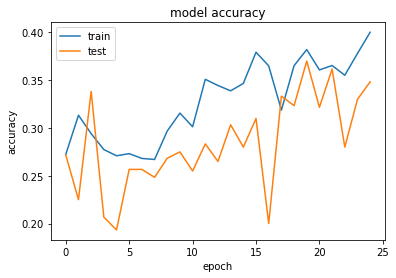

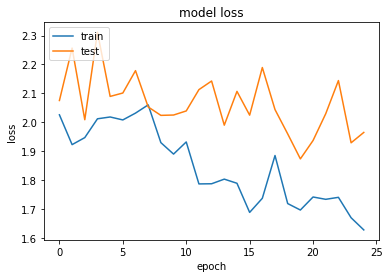

In [21]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.005


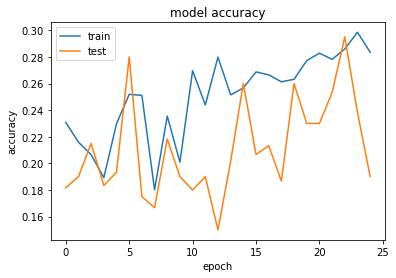

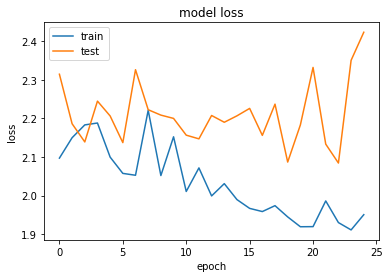

In [23]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.01


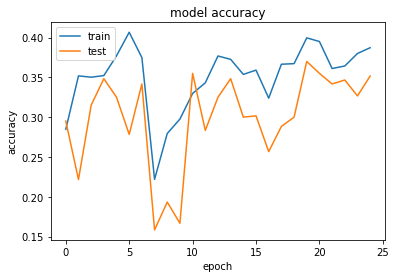

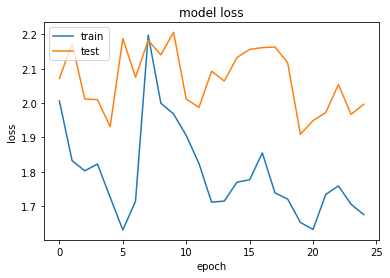

In [25]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.001

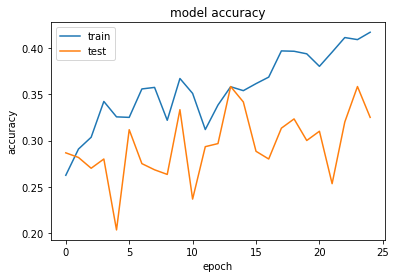

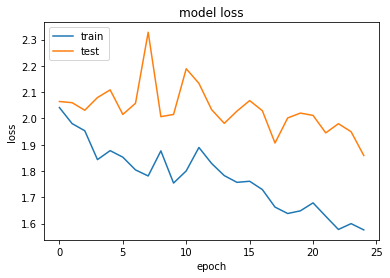

In [27]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 bi lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.003

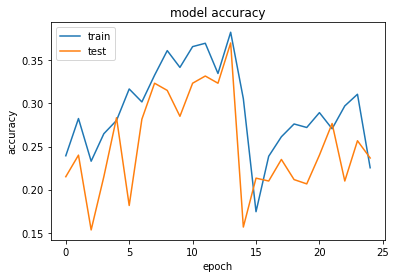

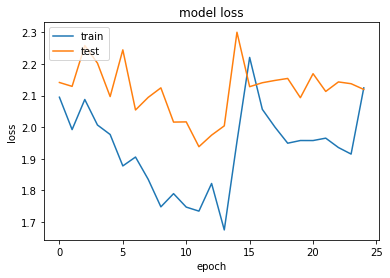

In [29]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 bi lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff w/dropout 0.2 between lstm and fc
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.003

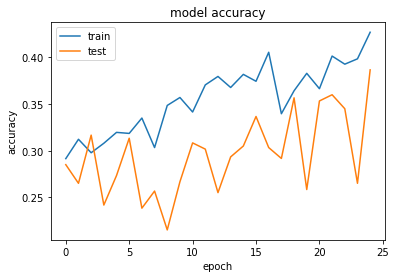

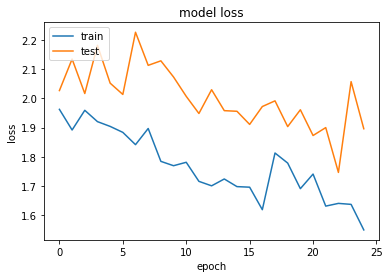

In [31]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 bi lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.003

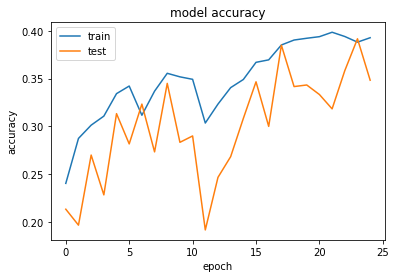

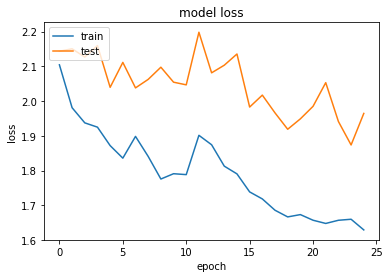

In [34]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 bi lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff w/ 64 dense
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.003

In [ ]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#128, 128 bi lstm, w/ chroma, zcr, mfcc, sp_centroid, sp_rolloff w/ 32 dense
#split data into groups of 6 (6 times the samples, each 6 times shorter) (XtrainLARGE3)
#adam 0.003